# Tic Tac Toe Machine Learning Initial Test

## Creating the data set

In [78]:
import numpy as np
from sklearn.model_selection import train_test_split 
data_set = np.genfromtxt(
    "Tic tac initial results.csv",
    delimiter=",",
    dtype=[("move_1",int),
        ("move_2",int),
        ("move_3",int),
        ("move_4",int),
        ("move_5",int),
        ("move_6",int),
        ("move_7",int),
        ("result",'U10')],
        names=True)

data = np.array([list(x)[:-1] for x in data_set])
labels = np.array([bool(x[-1]=="win") for x in data_set])
print(labels)
print(data)

X_train, X_test, y_train, y_test = train_test_split(data,labels,random_state=201)
print(len(X_train))
print(len(X_test))

[False  True False ...  True False  True]
[[ 0  8  1 ... -1 -1 -1]
 [ 4  7  2 ... -1 -1 -1]
 [ 0  8  1 ...  5 -1 -1]
 ...
 [ 4  5  7 ... -1 -1 -1]
 [ 6  2  0 ... -1 -1 -1]
 [ 4  7  1 ... -1 -1 -1]]
1827
609


## Training a KNN model
This is a test implementation to I will be using the sklearn neighbours classifier.

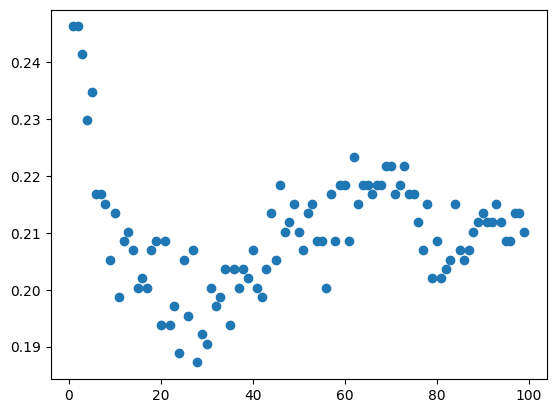

28
0.18719211822660098


KNeighborsClassifier(n_neighbors=28)

In [79]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
results = {
    "K_val":[],
    "error":[]
}
best_k = 0
best_error = np.inf
#Train models using multiple values of k to find the best.
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    error = 1-sum([pred[i]==y_test[i] for i in range(len(pred))])/len(pred)
    results["error"].append(error)
    results["K_val"].append(k)
    if error<best_error:
        best_k = k
        best_error = error

#Visual display of the results
plt.scatter(results["K_val"],results["error"])
plt.show()
print(best_k)
print(best_error)
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train,y_train)

### Getting moves from the model
Implemented a function to return the move the model is most confinant in playing.

In [80]:
#Use predict proba to find the most confident result
def next_move(model,moves):
    """
    Takes a trained model and the current position, returns the best predicted move.
    """
    #Gets list of all current turns
    moves = np.array([move for move in moves if move!=-1])
    if len(moves)>=7:
        return
    #Creates list of remaining turns to fill dimensions
    empty_moves = np.empty((1,6-len(moves)))
    empty_moves.fill(-1)
    
    predicted_move = 0
    max_con = 0
    for x in range(1,9):
        #Skips duplicates
        if x in moves: continue 
        #Generates test turn sequence
        test_move = np.append(np.append(moves,x),empty_moves)
        confidence = model.predict_proba([test_move])[0]
        #Tracks the move with the highest win confidence
        if confidence[1]>=max_con:
            max_con = confidence[1]
            predicted_move = x
    return predicted_move
         
next_move(knn,[])

8

This system is deeply flawed for this implementation as the database doesn't acount for opponent moves, it just looks at one persons moves. 

## Implementing Search algorithms
A much better method for my goal would be with implementing search algorithms to anticipate oponents moves.

In [ ]:
class board(object):
    """
    Object representing a tic tac toe board
    
    Variables:
        board - 1D array with len 9 representing all squares on the board
    
    Functions:
        is_valid_move - Returns True if the given move is valid, False otherwise.
        make_move - Adds the given move to the board.
        game_over - Returns the current outcome of the game: 1 or 2 if a player won, 0 if tie, and -1 if the game is not over.
    """

    def __init__(self,initial_state=None):
        """
        Initialises the board object.
        Arguments:
            intial_state- A list of the start state, becomes the board if given and valid.
        """
        assert(isinstance(initial_state,list))
        assert(len(initial_state)==9)
        if initial_state is None:
            self.board = np.zeros(9)
        else:
            self.board = initial_state.copy()
    
    def is_valid_move(self,square):
        """
        Checks if a move can be made on the given square.
        Returns True if the move is valid or False otherwise
        """
        if square<0 or square>=9: return False
        if self.board[square] != 0: return False
        return True

    def make_move(self,square,player):
        """
        Makes valid moves to the board.
        Arguments:
            square - The square to make the move on (0-9)
            player - The player making the move (1-2)
        """
        assert(self.is_valid_move(square))
        assert(player==1 or player==2)
        self.board[square]=player

    def game_over(self):
        """
        Evaluates if the game is finished.
        Returns the winning player (1 or 2), a draw (0) or -1 if the game is not over
        """
        winner = -1

        #Check rows for win
        for off in range(0,9,3):
            if winner != -1: break
            row = np.array([x for x in self.board[0+off:2+off] if x!=0])
            #Set if row winner
            if (row==1).sum()==3:
                winner = 1
            if (row==2).sum()==3:
                winner = 2
        
        #Check columns for win
        for off in range(0,9,3):
            if winner != -1: break
            col = np.array([x for x in self.board[0+off::3] if x!=0])
            #Set if col winner
            if (col==1).sum()==3:
                winner = 1
            if (col==2).sum()==3:
                winner = 2
        
        #Top left diag
        if winner == -1:
            left_diag = np.array([x for x in self.board[0::4] if x!=0])
            #Set if col winner
            if (left_diag==1).sum()==3:
                winner = 1
            if (left_diag==2).sum()==3:
                winner = 2
        
        #Top right diag
        if winner == -1:
            right_diag = np.array([x for x in self.board[6:1:-2] if x!=0])
            #Set if col winner
            print(right_diag)
            if (right_diag==1).sum()==3:
                winner = 1
            if (right_diag==2).sum()==3:
                winner = 2

        if winner == -1 and len([x for x in self.board[:] if x!=0])==9:
            winner = 0

        return winner

    def __str__(self):
        msg = ""
        for i in range(len(self.board)):
            match self.board[i]:
                case 0:
                    msg+="- "
                case 1:
                    msg+="X "
                case 2:
                    msg+="O "
            #Adds break to form 3X3 board
            if i%3==2:
                msg+="\n"
        return msg

board_ints = board([1,2,1,
       2,1,2,
       2,1,1])
print(board_ints.game_over())
print(board_ints)

1
X O X 
O X O 
O X X 

